# Ungraded Lab: Multiple LSTMs

In this lab, you will look at how to build a model with multiple LSTM layers. Since you know the preceding steps already (e.g. downloading datasets, preparing the data, etc.), we won't expound on it anymore so you can just focus on the model building code.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Load and Prepare the Dataset

In [1]:
import tensorflow_datasets as tfds

# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="./data/", download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.MIRZV5_1.0.0/imdb_reviews-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.MIRZV5_1.0.0/imdb_reviews-test.tfrecord*...:   0%|          …

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.MIRZV5_1.0.0/imdb_reviews-unsupervised.tfrecord*...:   0%|  …

Dataset imdb_reviews downloaded and prepared to data/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [2]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [3]:
import os
try:
    import wget
except ModuleNotFoundError:
    print("Installing wget module...")
    !pip install wget
    import wget

def download_dataset(url, folder, filename):
    # Check if the folder exists, otherwise, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_path = os.path.join(folder, filename)

    # Check if the file has already been downloaded
    if not os.path.exists(file_path):
        print(f"Downloading file from {url}...")
        wget.download(url, out=folder)
        print("\nDownload completed.")
    else:
        print("The file has already been downloaded.")

# Specify the URL of the file, the destination folder, and the filename
url = "https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt"
folder = "Vocabulary"
filename = "imdb_vocab_subwords.txt"

# Call the function to download the file.
download_dataset(url, folder, filename)

Installing wget module...
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c9b8f87f501b95bea5a84640a88a662f248dca3b6daca328575493faf19aa599
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget

Download completed.


In [4]:
import keras_nlp

# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./Vocabulary/imdb_vocab_subwords.txt'
)

Like the previous lab, we increased the `BATCH_SIZE` here to make the training faster. If you are doing this on your local machine and have a powerful processor, feel free to use the value used in the lecture (i.e. 64) to get the same results as Laurence.

In [5]:
import tensorflow as tf

# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [6]:
def padding_func(sequences):
  '''
  Generates padded sequences from a tf.data.Dataset.

  Args:
      sequences (tf.data.Dataset): Dataset containing the sequences to be padded.

  Returns:
      tf.data.Dataset: Dataset containing the padded sequences.
  '''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [7]:
def process_reviews_with_tokenizer(reviews, labels, subword_tokenizer, padding_func):
    """
    Generate integer sequences using the subword tokenizer, apply padding, and combine sequences with labels.

    Args:
        reviews (tf.data.Dataset): Dataset containing text reviews.
        labels (tf.data.Dataset): Dataset containing labels.
        subword_tokenizer: Subword tokenizer used to tokenize the reviews.
        padding_func: Function used to apply padding to the tokenized sequences.

    Returns:
        tf.data.Dataset: Dataset containing the tokenized and padded sequences along with their labels.
    """
    # Generate integer sequences using the subword tokenizer and apply padding
    sequences_subword = reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

    # Combine the integer sequences and labels
    dataset_vectorized = tf.data.Dataset.zip((sequences_subword, labels))

    return dataset_vectorized

train_dataset_vectorized = process_reviews_with_tokenizer(train_reviews, train_labels, subword_tokenizer, padding_func)
test_dataset_vectorized = process_reviews_with_tokenizer(test_reviews, test_labels, subword_tokenizer, padding_func)

In [8]:
def optimize_dataset(dataset_vectorized, shuffle=False):
    '''
    Optimizes the dataset for training.

    Args:
        dataset_vectorized (tf.data.Dataset): Dataset containing the vectorized data.
        shuffle (bool): Indicates whether to shuffle the dataset or not. Default is False.

    Returns:
        tf.data.Dataset: Optimized dataset with caching, prefetching, and batching applied.
    '''
    dataset_final = (dataset_vectorized.shuffle(SHUFFLE_BUFFER_SIZE) if shuffle else dataset_vectorized) \
                    .cache().prefetch(buffer_size=PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset_final

train_dataset_final = optimize_dataset(train_dataset_vectorized, shuffle=True)
test_dataset_final = optimize_dataset(test_dataset_vectorized)

## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when `return_sequences` is True.

In [9]:
import numpy as np

# Parameters
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 16
LSTM_DIM = 8

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'lstm output units: {LSTM_DIM}')

# Define array input with random values
random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(LSTM_DIM)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


The next cell implements the stacked LSTM architecture.

In [10]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

class MultiplesLSTMsModel:
    def __init__(self, vocab_size, embedding_dim, lstm1_dim, lstm2_dim, dense_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm1_dim = lstm1_dim
        self.lstm2_dim = lstm2_dim
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
          Input(shape=(None,)),
          Embedding(self.vocab_size, self.embedding_dim),
          Bidirectional(LSTM(self.lstm1_dim, return_sequences=True)),
          Bidirectional(LSTM(self.lstm2_dim)),
          Dense(self.dense_dim, activation='relu'),
          Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [11]:
# Model parameters
EMBEDDING_DIM = 64
LSTM1_DIM = 32
LSTM2_DIM = 16
DENSE_DIM = 64

# Create an instance of the SentimentModel class
model = MultiplesLSTMsModel(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM, LSTM1_DIM, LSTM2_DIM, DENSE_DIM)

# Print the summary
model.summary()

# Compile the model
model.compile_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 64)            │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 526,017 (2.01 MB)

 Trainable params: 526,017 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters, it will take around 2 minutes per epoch in your lab environment. Also, since this is a larger model, it might start to overfit quickly so you may want to use fewer epochs or use a callback to monitor the validation accuracy.

In [12]:
NUM_EPOCHS = 5

history = model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 752ms/step - accuracy: 0.6317 - loss: 0.6244 - val_accuracy: 0.8467 - val_loss: 0.3671
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 739ms/step - accuracy: 0.8713 - loss: 0.3136 - val_accuracy: 0.8626 - val_loss: 0.3268
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 761ms/step - accuracy: 0.9218 - loss: 0.2084 - val_accuracy: 0.8678 - val_loss: 0.3654
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 736ms/step - accuracy: 0.9253 - loss: 0.1963 - val_accuracy: 0.8491 - val_loss: 0.3879
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 75s 764ms/step - accuracy: 0.9205 - loss: 0.2053 - val_accuracy: 0.7888 - val_loss: 0.5336


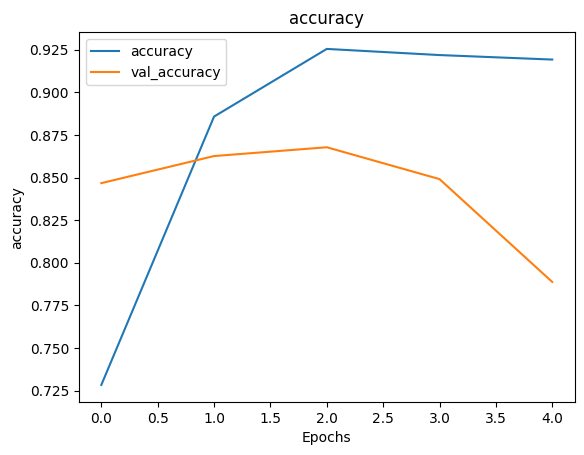

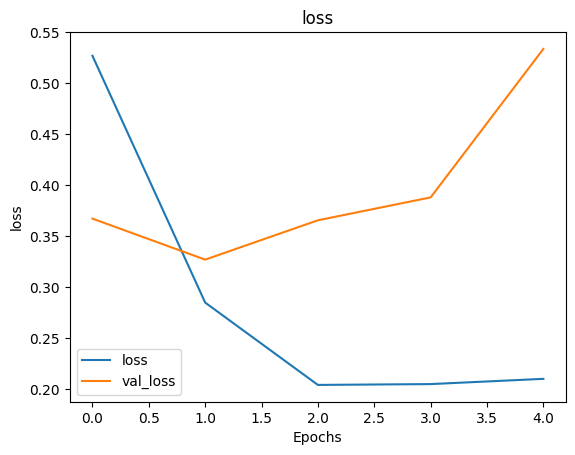

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    """
    Plots training and validation metrics over epochs.

    Args:
        history (History): History object returned by the fit method of a Keras model.
        metric (str): Metric name to plot (e.g., "accuracy", "loss").

    Returns:
        None: Displays a plot showing the training and validation metrics over epochs.
    """
    # Convert metric to lowercase
    metric = metric.lower()

    # Check if the metric exists in the history
    if metric not in history.history or f'val_{metric}' not in history.history:
        raise ValueError(f"Metric '{metric}' or 'val_{metric}' not found in history.")

    plt.figure()  # Create a new figure
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

try:
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
except ValueError as e:
  print("Error:", e)

## Save the history

In [14]:
import json
from google.colab import files

def save_history(history, filename):
    """
    Saves the training history to a file.

    Args:
        history (History): History object returned by the fit method of a Keras model.
        filename (str): Name of the file where the history will be saved.

    Returns:
        None: The function saves the history to the specified file.
    """
    # Save the dictionary to a JSON file
    with open(filename, 'w') as file:
        json.dump(history.history, file)

    # Download the JSON file
    files.download(filename)

save_history(history, 'history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Wrap Up

This lab showed how you can build deep networks by stacking LSTM layers. In the next labs, you will continue exploring other architectures you can use to implement your sentiment classification model.

As before, run the cell below to free up resources.

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)